In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.image import rgb_to_grayscale
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
from concurrent.futures import ThreadPoolExecutor
from tensorflow import keras
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir="/content/drive/MyDrive/Datasets/SMILEs"
negative_idx_file = os.path.join(base_dir,"smiles_01_neg.idx")
positive_idx_file = os.path.join(base_dir,"smiles_01_pos.idx")
image_paths=[]
labels=[]

with open (positive_idx_file,"r")as file:
  for line in file:
    parts=line.strip().split()
    image_paths.append(parts[0])
    labels.append(1)

with open (negative_idx_file,"r")as file:
  for line in file:
    parts=line.strip().split()
    image_paths.append(parts[0])
    labels.append(0)

In [ ]:
def process_image(path):
    full_path = os.path.join(base_dir, path)
    img = load_img(full_path, target_size=[64, 64])
    img = rgb_to_grayscale(img)
    img = img_to_array(img)
    return img

# Paralel işleme kullanarak görüntüleri işleme
with ThreadPoolExecutor() as executor:
    images = list(executor.map(process_image, image_paths))

images = np.array(images)
labels = np.array(labels)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images,labels,test_size=0.33,random_state=42)

In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((8763, 64, 64, 1), (4317, 64, 64, 1), (8763,), (4317,))

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
# model
model = keras.models.Sequential()
model.add(keras.Input(shape=(64,64))) # seq_length, input_size
model.add(layers.SimpleRNN(128, return_sequences=True, activation='relu'))
model.add(layers.LSTM(128, return_sequences=False, activation='relu'))
model.add(layers.Dense(2))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64, 128)           24704     
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 156546 (611.51 KB)
Trainable params: 156546 (611.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:

# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
lr=0.003
optim = keras.optimizers.Adam(learning_rate=lr)
metrics = ["accuracy"]
# Early Stopping tanımlama
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor='val_loss',  # İzlenecek metrik
#     patience=3,  # İyileşme olmayan epoch sayısı
#     restore_best_weights=True  # En iyi ağırlıkları geri yükle
# )

model.compile(loss=loss, optimizer=optim, metrics=metrics)


In [ ]:
# training
batch_size = 64
epochs = 10
# H = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, verbose=2,callbacks=[early_stopping])
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, verbose=2)
training_loss = H.history['loss']

Epoch 1/10
137/137 - 40s - loss: 0.5903 - accuracy: 0.7228 - val_loss: 0.5726 - val_accuracy: 0.7216 - 40s/epoch - 293ms/step
Epoch 2/10
137/137 - 35s - loss: 0.5772 - accuracy: 0.7234 - val_loss: 0.5591 - val_accuracy: 0.7216 - 35s/epoch - 257ms/step
Epoch 3/10
137/137 - 32s - loss: 0.5815 - accuracy: 0.7363 - val_loss: 0.5103 - val_accuracy: 0.7220 - 32s/epoch - 235ms/step
Epoch 4/10
137/137 - 32s - loss: 0.6439 - accuracy: 0.7672 - val_loss: 0.5190 - val_accuracy: 0.7533 - 32s/epoch - 233ms/step
Epoch 5/10
137/137 - 32s - loss: 0.3795 - accuracy: 0.8391 - val_loss: 0.3984 - val_accuracy: 0.8168 - 32s/epoch - 234ms/step
Epoch 6/10
137/137 - 33s - loss: 0.3462 - accuracy: 0.8586 - val_loss: 0.3188 - val_accuracy: 0.8670 - 33s/epoch - 237ms/step
Epoch 7/10
137/137 - 32s - loss: 0.3364 - accuracy: 0.8598 - val_loss: 0.3764 - val_accuracy: 0.8492 - 32s/epoch - 235ms/step
Epoch 8/10
137/137 - 31s - loss: 0.3244 - accuracy: 0.8685 - val_loss: 0.3075 - val_accuracy: 0.8735 - 31s/epoch - 228

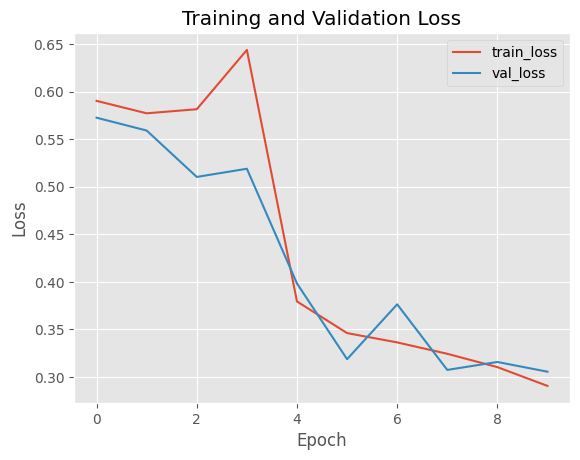

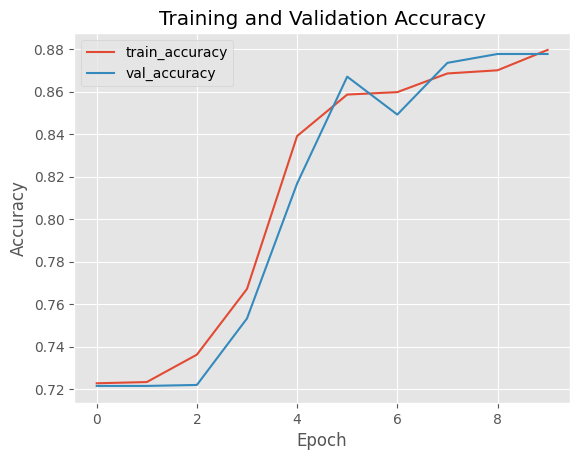

In [ ]:


# Create count of the number of epochs
epoch_count = len(H.history['loss'])
plt.style.use("ggplot")

# Plot training and validation loss
plt.figure()
plt.plot(np.arange(0, epoch_count), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch_count), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(np.arange(0, epoch_count), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, epoch_count), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()